<a href="https://colab.research.google.com/github/thalapandi/pandian_ml/blob/main/RNN_PT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building RNNs is Fun with PyTorch and Google Colab
In this tutorial, I will first teach you how to build a recurrent neural network (RNN) with a single layer, consisting of one single neuron, with PyTorch and Google Colab. I will also show you how to implement a simple RNN-based model for image classification.

This work is heavily inspired by Aurélien Géron's book called ["Hand-On Machine Learning with Scikit-Learn and TensorFlow"](https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/). Although his neural network implementations are purely in TensorFlow, I adopted/reused some notations/variables names and implemented things using PyTorch only. I really enjoyed his book and learned a lot from his explanations. His work inspired this tutorial and I strongly recommend the book.

We will be using Google Colab so we need to manually install the PyTorch library first. You can do this by using the following command:

In [ ]:
!pip3 install torch torchvision

Now we can import the necessary libraries we will use in the tutorial:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

### RNN with A Single Neuron


The idea of this tutorial is to show you the basic operations necessary for building an RNN architecture using PyTorch. This guide assumes you have knowledge of basic RNNs and that you have read the tutorial on [building neural networks from scratch using PyTorch](https://medium.com/dair-ai/a-simple-neural-network-from-scratch-with-pytorch-and-google-colab-c7f3830618e0). I will try to review RNNs wherever possible for those that need a refresher but I will keep it minimal.

First, let's build the computation graph for a single-layer RNN. Again, we are not concerned with the math for now, I just want to show you the PyTorch operations needed to build your RNN models.

For illustration purposes, this is the architecture we are building:

![alt txt](https://docs.google.com/drawings/d/e/2PACX-1vQXBLYvvI1dqAHdLA0hQdsP1PojmCfuSCMK2DXEL0uTvRUqvD1eYK8fsECcNCoekxCbgWJ-k7QF_1s4/pub?w=600&h=400)

And here is the code:

In [ ]:
class SingleRNN(nn.Module):
    def __init__(self, n_inputs, n_neurons):
        super(SingleRNN, self).__init__()

        self.Wx = torch.randn(n_inputs, n_neurons) # 4 X 1
        self.Wy = torch.randn(n_neurons, n_neurons) # 1 X 1

        self.b = torch.zeros(1, n_neurons) # 1 X 4

    def forward(self, X0, X1):
        self.Y0 = torch.tanh(torch.mm(X0, self.Wx) + self.b) # 4 X 1

        self.Y1 = torch.tanh(torch.mm(self.Y0, self.Wy) +
                            torch.mm(X1, self.Wx) + self.b) # 4 X 1

        return self.Y0, self.Y1

In the above code, I have implemented a simple one layer, one neuron RNN. I initialized two weight matrices, `Wx` and `Wy` with values from a normal distribution. `Wx` contains connection weights for the inputs of the current time step, while `Wy` contains connection weights for the outputs of the previous time step. We added a bias `b`. The `forward` function computes two outputs -- one for each time step... two in this case. Note that we are using `tanh` as the nonlinearity (activation function).

As for the input, we are providing 4 instances, with each instance containing two input sequences.

For illustration purposes, this is how the data is being fed into the RNN model:

![alt txt](https://docs.google.com/drawings/d/e/2PACX-1vRpQYtOzO1U_3yQLf1885kMaja6MsXtJ8QnlqxrfpTgZmb4WpewJXphGdmotYXDB1VE6zlW6cBY_WqR/pub?w=600&h=600)

And this is the code to test the model:

In [ ]:
N_INPUT = 4
N_NEURONS = 1

X0_batch = torch.tensor([[0,1,2,0], [3,4,5,0],
                         [6,7,8,0], [9,0,1,0]],
                        dtype = torch.float) #t=0 => 4 X 4

X1_batch = torch.tensor([[9,8,7,0], [0,0,0,0],
                         [6,5,4,0], [3,2,1,0]],
                        dtype = torch.float) #t=1 => 4 X 4

model = SingleRNN(N_INPUT, N_NEURONS)

Y0_val, Y1_val = model(X0_batch, X1_batch)

After we have fed the input into the computation graph, we obtain outputs for each timestep (`Y0`, `Y1`), which we can now print as follows:

In [ ]:
print(Y0_val)
print(Y1_val)

tensor([[-0.9984],
        [-1.0000],
        [-1.0000],
        [-1.0000]])
tensor([[-1.0000],
        [-0.2690],
        [-1.0000],
        [-1.0000]])


### Increasing Neurons in RNN Layer
Next, I will show you how to generalize the RNN we have just build to let the single layer support an `n` amount of neurons. In terms of the architecture, nothing really changes since we have already parameterized the number of neurons in the computation graph we have built. However, the size of the output changes since we have changed the size of number of units (i.e., neurons) in the RNN layer.

Here is an illustration of what we will build:

![alt txt](https://docs.google.com/drawings/d/e/2PACX-1vQov6BGg1fXOb7Bg5zenPh7R5j6VsZJh_D6JevQ_sm_fCxmXORxad3qLIFGG1FojzJig0qdcAQoGYoN/pub?w=600&h=404)

And here is the code:

In [ ]:
class BasicRNN(nn.Module):
    def __init__(self, n_inputs, n_neurons):
        super(BasicRNN, self).__init__()

        self.Wx = torch.randn(n_inputs, n_neurons) # n_inputs X n_neurons
        self.Wy = torch.randn(n_neurons, n_neurons) # n_neurons X n_neurons

        self.b = torch.zeros(1, n_neurons) # 1 X n_neurons

    def forward(self, X0, X1):
        self.Y0 = torch.tanh(torch.mm(X0, self.Wx) + self.b) # batch_size X n_neurons

        self.Y1 = torch.tanh(torch.mm(self.Y0, self.Wy) +
                            torch.mm(X1, self.Wx) + self.b) # batch_size X n_neurons

        return self.Y0, self.Y1

In [ ]:
N_INPUT = 3 # number of features in input
N_NEURONS = 5 # number of units in layer

X0_batch = torch.tensor([[0,1,2], [3,4,5],
                         [6,7,8], [9,0,1]],
                        dtype = torch.float) #t=0 => 4 X 3

X1_batch = torch.tensor([[9,8,7], [0,0,0],
                         [6,5,4], [3,2,1]],
                        dtype = torch.float) #t=1 => 4 X 3

model = BasicRNN(N_INPUT, N_NEURONS)

Y0_val, Y1_val = model(X0_batch, X1_batch)

Now when we print the outputs produced for each time step, it is of size (`4 X 5`), which represents the batch size and number of neurons, respectively.

In [ ]:
print(Y0_val)
print(Y1_val)

tensor([[ 0.8637,  0.9878, -0.1758, -0.7462, -0.9552],
        [ 0.9995,  1.0000,  0.6667, -0.9998, -0.9814],
        [ 1.0000,  1.0000,  0.9454, -1.0000, -0.9924],
        [-0.8953,  1.0000,  1.0000, -0.9836,  0.9999]])
tensor([[ 1.0000,  1.0000,  0.9154, -1.0000,  0.9993],
        [ 0.1450, -0.9337, -0.9938, -0.9316,  0.9942],
        [ 0.9997,  1.0000, -0.8217, -1.0000,  0.9984],
        [-0.6636,  0.9985,  0.0432, -0.9922,  0.2622]])


### PyTorch Built-in RNN Cell

If you take a closer look at the `BasicRNN` computation graph we have just built, it has a serious flaw. What if we wanted to build an architecture that supports extremely large inputs and outputs. The way it is currently built, it would require us to individually compute the outputs for every time step, increasing the lines of code needed to implement the desired computation graph. Below I will show you how to consolidate and implement this more efficiently and cleanly using the built-in RNNCell module.

Let's first try to implement this informally to analyze the role `RNNCell` plays:

In [ ]:
rnn = nn.RNNCell(3, 5) # n_input X n_neurons

X_batch = torch.tensor([[[0,1,2], [3,4,5],
                         [6,7,8], [9,0,1]],
                        [[9,8,7], [0,0,0],
                         [6,5,4], [3,2,1]]
                       ], dtype = torch.float) # X0 and X1

hx = torch.randn(4, 5) # m X n_neurons
output = []

# for each time step
for i in range(2):
    hx = rnn(X_batch[i], hx)
    output.append(hx)

print(output)

[tensor([[-0.6909,  0.5620,  0.2721, -0.2241,  0.0939],
        [-0.5744,  0.4671, -0.4800,  0.9956, -0.7457],
        [-0.5976,  0.5328, -0.9615,  1.0000, -0.7355],
        [ 0.9859, -0.6745, -0.9990,  0.9984,  0.2917]], grad_fn=<TanhBackward>), tensor([[-0.7276,  0.3742, -0.9864,  1.0000, -0.8790],
        [ 0.1334,  0.1078,  0.0161, -0.4180, -0.2246],
        [-0.3839,  0.2674, -0.9703,  0.9991, -0.7527],
        [ 0.7661,  0.0675, -0.9386,  0.9704, -0.3403]], grad_fn=<TanhBackward>)]


With the above code, we have basically implemented the same model that was implemented in `BasicRNN`. `torch.RNNCell(...)` does all the magic of creating and maintaining the necessary weights and biases for us. `torch.RNNCell` accepts a tensor as input and outputs the next hidden state for each element in the batch. Read more about this module [here](https://pytorch.org/docs/stable/nn.html?highlight=rnncell#torch.nn.RNNCell).

Now, let's formally build the computation graph using the same information we used above.

In [ ]:
class CleanBasicRNN(nn.Module):
    def __init__(self, batch_size, n_inputs, n_neurons):
        super(CleanBasicRNN, self).__init__()

        self.rnn = nn.RNNCell(n_inputs, n_neurons)
        self.hx = torch.randn(batch_size, n_neurons) # initialize hidden state

    def forward(self, X):
        output = []

        # for each time step
        for i in range(2):
            self.hx = self.rnn(X[i], self.hx)
            output.append(self.hx)

        return output, self.hx

In [ ]:
FIXED_BATCH_SIZE = 4 # our batch size is fixed for now
N_INPUT = 3
N_NEURONS = 5

X_batch = torch.tensor([[[0,1,2], [3,4,5],
                         [6,7,8], [9,0,1]],
                        [[9,8,7], [0,0,0],
                         [6,5,4], [3,2,1]]
                       ], dtype = torch.float) # X0 and X1


model = CleanBasicRNN(FIXED_BATCH_SIZE, N_INPUT, N_NEURONS)
output_val, states_val = model(X_batch)
print(output_val) # contains all output for all timesteps
print(states_val) # contain values for final state or final timestep, i.e., t=1

[tensor([[ 0.4909,  0.6246,  0.2240,  0.4163,  0.9287],
        [-0.3733, -0.3016,  0.9961,  1.0000,  0.9759],
        [-0.3570, -0.6732,  0.9999,  1.0000,  0.9993],
        [-0.9648, -0.5048, -0.5303,  0.9903,  0.3518]], grad_fn=<TanhBackward>), tensor([[-0.6901, -0.8889,  0.9998,  1.0000,  0.9993],
        [ 0.6467, -0.8708, -0.6372,  0.1005,  0.5848],
        [-0.2918, -0.9729,  0.9811,  1.0000,  0.9881],
        [-0.1899, -0.9033,  0.3249,  0.9862,  0.6411]], grad_fn=<TanhBackward>)]
tensor([[-0.6901, -0.8889,  0.9998,  1.0000,  0.9993],
        [ 0.6467, -0.8708, -0.6372,  0.1005,  0.5848],
        [-0.2918, -0.9729,  0.9811,  1.0000,  0.9881],
        [-0.1899, -0.9033,  0.3249,  0.9862,  0.6411]], grad_fn=<TanhBackward>)


You can see how the code is much cleaner since we don't need to explicitly operate on the weights as shown in the previous code snippet  --  everything is handled implicitly and eloquently behind the scenes by PyTorch.

### RNN for Image Classification

![alt txt](https://docs.google.com/drawings/d/e/2PACX-1vSiMstqkE9hTYmhPD3KMeFRNNKYA2NnrCayahBOEL1TalRqaWF7rH8a7O-nP9c-mKOdZRsWtmAGZfNN/pub?w=969&h=368)

Now that you have learned how to build a simple RNN from scratch and using the built-in `RNNCell` module provided in PyTorch, let's do something more sophisticated and special.

Let's try to build an image classifier using the MNIST dataset. The MNIST dataset consists of images that contain hand-written numbers from 1–10. Essentially, we want to build a classifier to predict the numbers displayed by a set of images. I know this sounds strange but you will be surprised by how well RNNs perform on this image classification task.

In addition, we will also be using the `RNN` module instead of the `RNNCell` module since we want to generalize the computation graph to be able to support an `n` number of layers as well. We will only use one layer in the following computation graph, but you can experiment with the code later on by adding more layers.

#### Importing the dataset
Before building the RNN-based computation graph, let's import the MNIST dataset, split it into test and train portions, do a few transformations, and further explore it. You will need the following PyTorch libraries and lines of code to download and import the MNIST dataset to Google Colab.

In [ ]:
import torchvision
import torchvision.transforms as transforms

In [ ]:
BATCH_SIZE = 64

# list all transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

# download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


The code above loads and prepares the dataset to be fed into the computation graph we will build later on. Take a few minutes to play around with the code and understand what is happening. Notice that we needed to provide a batch size. This is because `trainloader` and `testloader` are iterators which will make it easier when we are iterating on the dataset and training our RNN model with minibatches.

#### Exloring the dataset
Here is a few lines of code to explore the dataset. I won't cover much of what's going on here, but you can take some time and look at it by yourself.

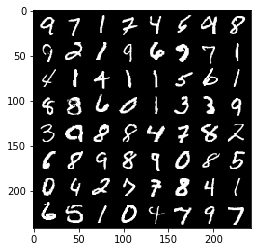

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

#### Model
Let's construct the computation graph. Below are the parameters:

In [ ]:
# parameters
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

And finally, here is a figure of the RNN-based classification model we are building:

![alt txt](https://docs.google.com/drawings/d/e/2PACX-1vQWhELhewvq_bHgqwf4vwDb5B9DN9-jAxeTF9Y73zr-OsW6OXC-ngxAfojivXyZEhjzLXceTZU2Ncz3/pub?w=550&h=600)

And here is the code for the model:

In [ ]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()

        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons)

        self.FC = nn.Linear(self.n_neurons, self.n_outputs)

    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))

    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2)

        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()

        # lstm_out => n_steps, batch_size, n_neurons (hidden states for each time step)
        # self.hidden => 1, batch_size, n_neurons (final state from each lstm_out)
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)
        out = self.FC(self.hidden)

        return out.view(-1, self.n_outputs) # batch_size X n_output

The `ImageRNN` model is doing the following:
- The initialization function `__init__(...)` declares a few variables, and then a basic RNN layer `basic_rnn` followed by a fully-connected layer `self.FC`.
- The `init_hidden` function initializes hidden weights with zero values.
The `forward` function accepts an input of size `n_steps X batch_size X n_neurons`. Then the data flows through the RNN layer and then through the fully-connected layer.
- The output are the log probabilities of the model.

#### Testing the model with some samples
A very good practice encouraged by PyTorch developers throughout their documentation, and which I really like and highly recommend, is to always test the model with a portion of the dataset before actual training. This is to ensure that you have the correct dimension specified and that the model is outputing the information you expect. Below I show an example of how to test your model:

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[-0.0918,  0.0176,  0.0474, -0.0849, -0.0141,  0.1235,  0.0070,  0.0719,
          0.0072, -0.0563],
        [-0.1017,  0.0276,  0.0580, -0.0783, -0.0150,  0.1127,  0.0171,  0.0749,
          0.0092, -0.0654],
        [-0.0941,  0.0234,  0.0402, -0.0825, -0.0402,  0.1208,  0.0117,  0.0753,
          0.0188, -0.0701],
        [-0.1021,  0.0160,  0.0551, -0.0886, -0.0132,  0.1113,  0.0136,  0.0634,
         -0.0021, -0.0533],
        [-0.0874,  0.0227,  0.0468, -0.0806, -0.0118,  0.1191,  0.0105,  0.0696,
          0.0077, -0.0581],
        [-0.0929,  0.0256,  0.0636, -0.0729, -0.0147,  0.1028,  0.0197,  0.0766,
          0.0140, -0.0700],
        [-0.0960,  0.0257,  0.0497, -0.0822, -0.0177,  0.1183,  0.0120,  0.0728,
          0.0047, -0.0644],
        [-0.0962,  0.0185,  0.0586, -0.0732, -0.0197,  0.1047,  0.0119,  0.0760,
          0.0104, -0.0641],
        [-0.0880,  0.0151,  0.0478, -0.0839, -0.0210,  0.1098,  0.0152,  0.0732,
          0.0105, -0.0578],
        [-0.0929,  

#### Training

Now let's look at the code for training the image classification model. But first, let's declare a few helper functions needed to train the model:

In [ ]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

Before training a model in PyTorch, you can programatically specify what device you want to use during training; the `torch.device(...)` function tells the program that we want to use the GPU if one is available, otherwise the CPU will be the default device.

Then we create an instance of the model, `ImageRNN(...)``, with the proper parameters. The criterion represents the function we will use to compute the loss of the model. The `nn.CrossEntropyLoss()` function basically applies a log softmax followed by a negative log likelihood loss operation over the output of the model. To compute the loss, the function needs both the log probabilities and targets. We will see later in our code how to provide this to the criterion.

For training, we also need an optimization algorithm which helps to update weights based on the current loss. This is achieved with the `optim.Adam` optimization function, which requires the model parameters and a learning rate. Alternatively, you can also use `optim.SGD` or any other optimization algorithm that's available.

The `get_accuracy(...)` function simply computes the accuracy of the model given the log probabilities and target values. As an exercise, you can write code to test this function as we did with the model before.

Let's put everything together and train our image classification model:

In [ ]:
for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()

    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()

        # reset hidden states
        model.hidden = model.init_hidden()

        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28)

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)

    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f'
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.8915 | Train Accuracy: 70.15
Epoch:  1 | Loss: 0.4040 | Train Accuracy: 87.86
Epoch:  2 | Loss: 0.2492 | Train Accuracy: 92.83
Epoch:  3 | Loss: 0.1951 | Train Accuracy: 94.30
Epoch:  4 | Loss: 0.1736 | Train Accuracy: 94.93
Epoch:  5 | Loss: 0.1598 | Train Accuracy: 95.43
Epoch:  6 | Loss: 0.1394 | Train Accuracy: 95.97
Epoch:  7 | Loss: 0.1339 | Train Accuracy: 96.15
Epoch:  8 | Loss: 0.1283 | Train Accuracy: 96.30
Epoch:  9 | Loss: 0.1250 | Train Accuracy: 96.39


We can also compute accuracy on the testing dataset to test how well the model performs on the image classification task. As you can see below, our RNN model is performing very well on the MNIST classification task.


In [ ]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)

print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 96.50


### Final Words
Please notice that we are not using GPU in this tutorial since the models we are building are relatively simple. As an exercise, you can take a look at the [PyTorch documentation](https://pytorch.org/docs/stable/notes/cuda.html) to learn how to program specific operations to execute on the GPU. You can then try to optimize the code to run on the GPU. If you need help with this, reach out to me on [Twitter](https://twitter.com/omarsar0).

That's it for this tutorial. Congratulations! You are now able to implement a basic RNN in PyTorch. You also learned how to apply RNNs to solve a real-world, image classification problem.

In the next tutorial, we will do more advanced things with RNNs and try to solve even more complex problems, such as sarcasm detection and sentiment classification. Until next time!

### References
- [A Simple Neural Network from Scratch with PyTorch and Google Colab](https://github.com/omarsar/pytorch_intro_neural_network/blob/master/nn.ipynb)
- [Hands on Machine Learning with Scikit-learn and Tensorflow](http://shop.oreilly.com/product/0636920052289.do)

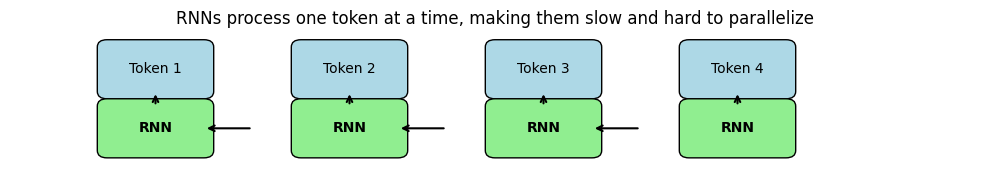

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 2))
ax.set_xlim(0, 10)
ax.set_ylim(0, 2)
ax.axis('off')

# Token input labels
tokens = ["Token 1", "Token 2", "Token 3", "Token 4"]
positions = [1, 3, 5, 7]

# Draw token input circles and arrows
for i, (token, x) in enumerate(zip(tokens, positions)):
    circle = patches.FancyBboxPatch((x, 1.2), 1, 0.6, boxstyle="round,pad=0.1", edgecolor="black", facecolor="lightblue")
    ax.add_patch(circle)
    ax.text(x + 0.5, 1.5, token, ha='center', va='center', fontsize=10)

    # RNN Box
    rnn_box = patches.FancyBboxPatch((x, 0.4), 1, 0.6, boxstyle="round,pad=0.1", edgecolor="black", facecolor="lightgreen")
    ax.add_patch(rnn_box)
    ax.text(x + 0.5, 0.7, "RNN", ha='center', va='center', fontsize=10, weight='bold')

    # Arrow from token to RNN
    ax.annotate("", xy=(x + 0.5, 1.2), xytext=(x + 0.5, 1.0), arrowprops=dict(arrowstyle="->", lw=1.5))

    # Arrow from RNN to next RNN
    if i < len(tokens) - 1:
        ax.annotate("", xy=(x + 1, 0.7), xytext=(x + 1.5, 0.7), arrowprops=dict(arrowstyle="->", lw=1.5))

# Title
plt.title("RNNs process one token at a time, making them slow and hard to parallelize", fontsize=12)
plt.tight_layout()
plt.show()


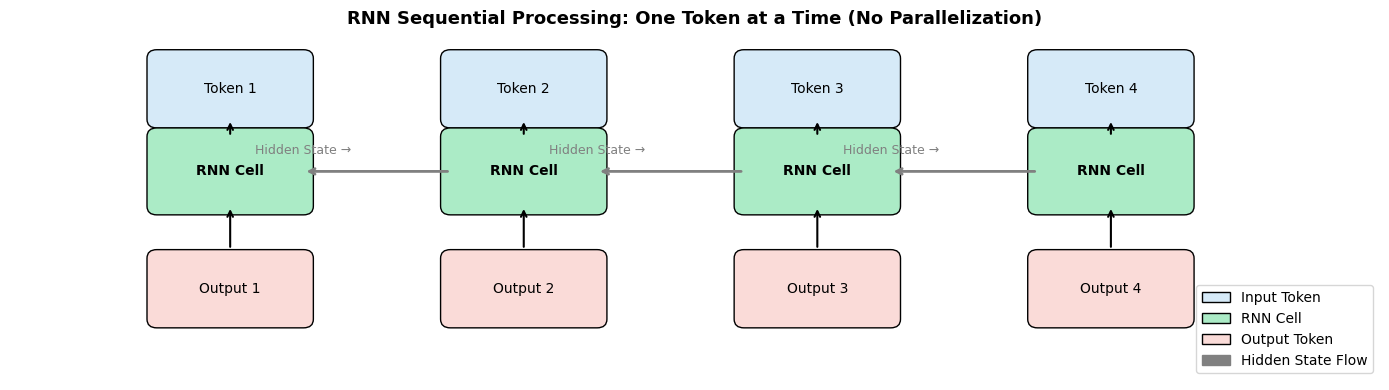

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Setup
fig, ax = plt.subplots(figsize=(14, 4))
ax.set_xlim(0, 14)
ax.set_ylim(0, 4)
ax.axis('off')

# Positions
positions = [1.5, 4.5, 7.5, 10.5]
tokens = ["Token 1", "Token 2", "Token 3", "Token 4"]
outputs = ["Output 1", "Output 2", "Output 3", "Output 4"]

for i, x in enumerate(positions):
    # Input tokens
    token_box = patches.FancyBboxPatch((x, 3), 1.5, 0.7, boxstyle="round,pad=0.1", edgecolor="black", facecolor="#D6EAF8")
    ax.add_patch(token_box)
    ax.text(x + 0.75, 3.35, tokens[i], ha='center', va='center', fontsize=10)

    # RNN cell
    rnn_box = patches.FancyBboxPatch((x, 2), 1.5, 0.8, boxstyle="round,pad=0.1", edgecolor="black", facecolor="#ABEBC6")
    ax.add_patch(rnn_box)
    ax.text(x + 0.75, 2.4, f"RNN Cell", ha='center', va='center', fontsize=10, weight='bold')

    # Output token
    output_box = patches.FancyBboxPatch((x, 0.7), 1.5, 0.7, boxstyle="round,pad=0.1", edgecolor="black", facecolor="#FADBD8")
    ax.add_patch(output_box)
    ax.text(x + 0.75, 1.05, outputs[i], ha='center', va='center', fontsize=10)

    # Arrows
    ax.annotate("", xy=(x + 0.75, 3), xytext=(x + 0.75, 2.8), arrowprops=dict(arrowstyle="->", lw=1.5))
    ax.annotate("", xy=(x + 0.75, 2), xytext=(x + 0.75, 1.5), arrowprops=dict(arrowstyle="->", lw=1.5))

    # Hidden state arrow
    if i < len(positions) - 1:
        ax.annotate("",
                    xy=(x + 1.5, 2.4), xytext=(positions[i+1], 2.4),
                    arrowprops=dict(arrowstyle="->", lw=2, color="gray"))
        ax.text((x + positions[i+1]) / 2, 2.6, "Hidden State →", ha='center', fontsize=9, color="gray")

# Title
plt.title("RNN Sequential Processing: One Token at a Time (No Parallelization)", fontsize=13, weight='bold')

# Legend
legend_elements = [
    patches.Patch(facecolor="#D6EAF8", edgecolor='black', label='Input Token'),
    patches.Patch(facecolor="#ABEBC6", edgecolor='black', label='RNN Cell'),
    patches.Patch(facecolor="#FADBD8", edgecolor='black', label='Output Token'),
    patches.FancyArrow(0, 0, 1, 0, color='gray', label='Hidden State Flow')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()
